In [1]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
from snntorch import utils
from snntorch import functional as SF
from snntorch import surrogate

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tonic import DiskCachedDataset
import tonic

import matplotlib.pyplot as plt
import numpy as np
import itertools
from tqdm import tqdm

from custom_data import LoadDataset
import custom_data
from model import model, compute_loss

import matplotlib.pyplot as plt
from IPython.display import HTML

from collections import defaultdict


In [2]:


# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# Temporal Dynamics
num_steps = 10
beta = 0.95
dataset_path = "dataset/"
batch_size = 16

train_dataset = LoadDataset(dir = dataset_path, train=True)
test_dataset = LoadDataset(dir = dataset_path,  train=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=custom_data.custom_collate, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=custom_data.custom_collate, shuffle=False,)


def print_batch_accuracy(data, label, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((label == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")





spike_grad = surrogate.atan()
net = model.fcn(beta=beta, spike_grad=spike_grad).to(device)


def forward_pass(net, data):
    spk_rec = []
    utils.reset(net)  # resets hidden states for all LIF neurons in net

    for step in range(data.size(0)):  # data.size(0) = number of time steps
        spk_out, mem_out = net(data[step])
        spk_rec.append(spk_out)

    spk_rec = torch.stack(spk_rec)
    spk_cnt = compute_loss.spike_count(spk_rec, channel=True)# batch channel(n_class) pixel pixel 
    pred_pro = torch.sigmoid(spk_cnt)# batch channel(n_class) pixel pixel
    return pred_pro

optimizer = torch.optim.Adam(net.parameters(), lr=10e-4, betas=(0.9, 0.999))
# loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)
criterion = nn.CrossEntropyLoss()

num_epochs = 50
num_iters = 50
pixel = 64
correct_rate = 0.8
loss_hist = []
hist = defaultdict(list)
# training loop
for epoch in tqdm(range(num_epochs)):
    for i, (data, label) in enumerate(iter(train_loader)):
        data = data.to(device)
        # label = torch.tensor(label, dtype=torch.int64)
        label = label.type(torch.int64)
        label = label.to(device)
        batch = len(data[0])
        data = data.reshape(num_steps, batch, 1, pixel, pixel)
        # print(data.shape)
        net.train()
        pred_pro = forward_pass(net, data)# batch, channel, pixel ,pixel
        loss_val = criterion(pred_pro, label)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        hist['loss'].append(loss_val.item())

        # print(f"Epoch {epoch}, Iteration {i} /nTrain Loss: {loss_val.item():.2f}")

        acc = compute_loss.culc_iou(pred_pro, label, correct_rate)
        hist['train'].append(acc)

        # print(f"Accuracy: {acc * 100:.2f}%/n")
        # spk_count_batch = (spk_rec==1).sum().item()
        # spk_count_batch /= batch
        # tqdm.write(f'{spk_count_batch}')
    
    tqdm.write(f'{acc=}')
    with torch.no_grad():
        net.eval()
        for i, (data, label) in enumerate(iter(test_loader)):
            data = data.to(device)
            label = label.to(device)
            label = label.type(torch.int64)
            batch = len(data[0])
            data = data.reshape(num_steps, batch, 1, pixel, pixel)
            pred_pro = forward_pass(net, data)
            loss_val = criterion(pred_pro, label)
            acc = compute_loss.culc_iou(pred_pro, label, correct_rate)
            hist['test'].append(acc)


  0%|          | 0/50 [00:06<?, ?it/s]

acc=0.0


  2%|▏         | 1/50 [00:11<06:11,  7.59s/it]

acc=0.0


  4%|▍         | 2/50 [00:15<04:35,  5.75s/it]

acc=0.0


  6%|▌         | 3/50 [00:20<04:02,  5.15s/it]

acc=0.0


  8%|▊         | 4/50 [00:24<03:45,  4.91s/it]

acc=0.0


 10%|█         | 5/50 [00:29<03:33,  4.75s/it]

acc=0.0


 12%|█▏        | 6/50 [00:33<03:25,  4.67s/it]

acc=0.0


 14%|█▍        | 7/50 [00:38<03:18,  4.60s/it]

acc=0.0


 16%|█▌        | 8/50 [00:42<03:11,  4.56s/it]

acc=0.0


 18%|█▊        | 9/50 [00:47<03:05,  4.53s/it]

acc=0.0


 20%|██        | 10/50 [00:51<03:00,  4.50s/it]

acc=0.0


 22%|██▏       | 11/50 [00:56<02:56,  4.53s/it]

acc=0.0


 24%|██▍       | 12/50 [01:00<02:51,  4.51s/it]

acc=0.0


 26%|██▌       | 13/50 [01:05<02:46,  4.50s/it]

acc=0.0


 28%|██▊       | 14/50 [01:09<02:40,  4.47s/it]

acc=0.0


 30%|███       | 15/50 [01:13<02:35,  4.44s/it]

acc=0.0


 32%|███▏      | 16/50 [01:18<02:30,  4.44s/it]

acc=0.0


 34%|███▍      | 17/50 [01:22<02:26,  4.44s/it]

acc=0.0


 36%|███▌      | 18/50 [01:27<02:22,  4.45s/it]

acc=0.0


 38%|███▊      | 19/50 [01:31<02:18,  4.46s/it]

acc=0.0


 40%|████      | 20/50 [01:36<02:14,  4.48s/it]

acc=0.0


 42%|████▏     | 21/50 [01:40<02:09,  4.47s/it]

acc=0.0


 44%|████▍     | 22/50 [01:45<02:05,  4.47s/it]

acc=0.0


 46%|████▌     | 23/50 [01:49<02:01,  4.50s/it]

acc=0.0


 48%|████▊     | 24/50 [01:54<01:56,  4.49s/it]

acc=0.0


 50%|█████     | 25/50 [01:58<01:51,  4.46s/it]

acc=0.0


 52%|█████▏    | 26/50 [02:03<01:47,  4.49s/it]

acc=0.0


 54%|█████▍    | 27/50 [02:07<01:43,  4.51s/it]

acc=0.0


 56%|█████▌    | 28/50 [02:12<01:38,  4.50s/it]

acc=0.0


 58%|█████▊    | 29/50 [02:16<01:34,  4.49s/it]

acc=0.0


 60%|██████    | 30/50 [02:21<01:29,  4.48s/it]

acc=0.0


 62%|██████▏   | 31/50 [02:25<01:24,  4.46s/it]

acc=0.0


 64%|██████▍   | 32/50 [02:30<01:19,  4.44s/it]

acc=0.0


 66%|██████▌   | 33/50 [02:34<01:16,  4.48s/it]

acc=0.0


 68%|██████▊   | 34/50 [02:39<01:12,  4.54s/it]

acc=0.0


 70%|███████   | 35/50 [02:43<01:08,  4.55s/it]

acc=0.0


 72%|███████▏  | 36/50 [02:48<01:03,  4.52s/it]

acc=0.0


 74%|███████▍  | 37/50 [02:52<00:58,  4.51s/it]

acc=0.0


 76%|███████▌  | 38/50 [02:57<00:53,  4.48s/it]

acc=0.0


 78%|███████▊  | 39/50 [03:01<00:49,  4.46s/it]

acc=0.0


 80%|████████  | 40/50 [03:05<00:44,  4.45s/it]

acc=0.0


 82%|████████▏ | 41/50 [03:10<00:39,  4.43s/it]

acc=0.0


 84%|████████▍ | 42/50 [03:14<00:35,  4.43s/it]

acc=0.0


 86%|████████▌ | 43/50 [03:19<00:30,  4.43s/it]

acc=0.0


 88%|████████▊ | 44/50 [03:23<00:26,  4.43s/it]

acc=0.0


 90%|█████████ | 45/50 [03:28<00:22,  4.45s/it]

acc=0.0


 92%|█████████▏| 46/50 [03:32<00:17,  4.47s/it]

acc=0.0


 94%|█████████▍| 47/50 [03:37<00:13,  4.48s/it]

acc=0.0


 96%|█████████▌| 48/50 [03:41<00:08,  4.49s/it]

acc=0.0


 98%|█████████▊| 49/50 [03:46<00:04,  4.48s/it]

acc=0.0


100%|██████████| 50/50 [03:46<00:00,  4.54s/it]


success model saving
defaultdict(<class 'list'>, {'loss': [0.5436854958534241, 0.5704233050346375, 0.5955213308334351, 0.5423644781112671, 0.5534558892250061, 0.572389543056488, 0.6109172701835632, 0.5631504058837891, 0.5511859655380249, 0.613619863986969, 0.5643271207809448, 0.5523095726966858, 0.5769520998001099, 0.5546857714653015, 0.5937296748161316, 0.5621210336685181, 0.5923317670822144, 0.6109896898269653, 0.5886915326118469, 0.5725009441375732, 0.5933825969696045, 0.5652814507484436, 0.580146849155426, 0.600883960723877, 0.5698355436325073, 0.5684418678283691, 0.5899176001548767, 0.564184844493866, 0.5923622846603394, 0.5322531461715698, 0.5681448578834534, 0.6352145075798035, 0.5852340459823608, 0.6194199919700623, 0.5430289506912231, 0.5785629153251648, 0.5520990490913391, 0.5708941221237183, 0.5753491520881653, 0.5453212261199951, 0.5513222813606262, 0.5753339529037476, 0.5839013457298279, 0.606290876865387, 0.5927581787109375, 0.5500961542129517, 0.5634157061576843, 0.59142

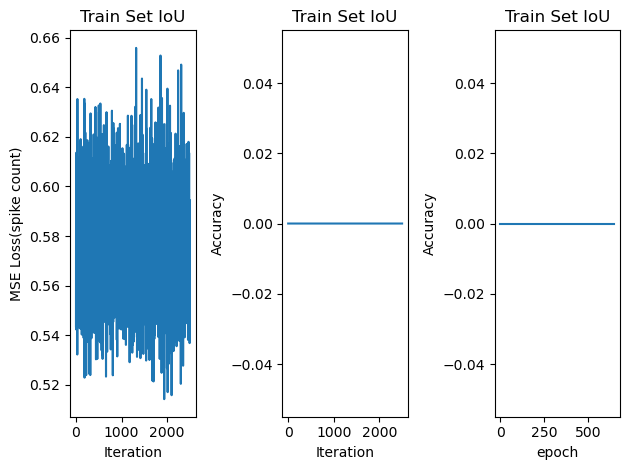

In [3]:

## save model
enddir = "models/model1.pth"
torch.save(net.state_dict(), enddir)
print("success model saving")
# Plot Loss
print(hist)
fig = plt.figure(facecolor="w")
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
ax1.plot(hist['loss'], label="train")
ax1.set_title("Train Set IoU")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("MSE Loss(spike count)")
ax2.plot(hist['train'], label="train")
ax2.set_title("Train Set IoU")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Accuracy")
ax3.plot(hist['test'], label='test')
ax3.set_title("Train Set IoU")
ax3.set_xlabel("epoch")
ax3.set_ylabel("Accuracy")
fig.tight_layout()

plt.show()




# idx = 0

# fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
# labels=['0', '1']
# print(f"The target label is: {label[idx]}")
# plt.rcParams['animation.ffmpeg_path'] = r'C:/Users/oosim/Downloads/ffmpeg-master-latest-win64-gpl/ffmpeg-master-latest-win64-gpl/bin'
# #  Plot spike count histogram
# # print(spk_rec.shape) #torch.Size([time, batch label])
# anim = splt.spike_count(spk_rec[:, idx].detach().cpu(), fig, ax, labels=labels,
#                         animate=True, interpolate=1)

# HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")